### Compare different formulation of the Peierls and Yield stress.

In the note book, I compared the values from yield criterias and Peierls rheologies.

Then I show the strength profile of the 2-d model I ran.
The version of model is representative by the file

    EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9/case.prm

and might be different from cases run later.

To make more sense, I output the values of the flow law parameters used in this jupyter notebook when it comes to that block.
Diffusion creep (in UI): 

    {'A': 2.4536068376072544e-17, 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 285000.0, 'V': 6.9e-06}

Dislocation creep (in UI): 

    {'A': 1.3930166603371937e-16, 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 490000.0, 'V': 1.34e-05}

I use the Mei 10 flow law for the Peierls creep and a brittle yielding with

    tau_0 = 50e6
    tau_m = 500e6
    friction = 0.47

I also demonstrate the effects of the Peierls creep by turning in on and off in the notebook and plot the difference on viscosity.

In [1]:
import os, sys
import numpy as np
from shutil import rmtree, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm

from cmcrameri import cm as ccm  # These are only available on my workstation
plt.style.use('publication_lhy11009')

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')

if os.path.abspath(ASPECT_LAB_DIR) not in sys.path:
  sys.path.append(os.path.abspath(ASPECT_LAB_DIR))

if os.path.abspath("/home/lochy/ASPECT_PROJECT/HaMaGeoLib/") not in sys.path:
  sys.path.append(os.path.abspath("/home/lochy/ASPECT_PROJECT/HaMaGeoLib/"))


import shilofue.Rheology as Rheology
import shilofue.ThermalModel as ThermalModel


import hamageolib.utils.plot_helper as plot_helper


# define global parameters
g = 9.81
rho_m = 3300.0 # mantle density
year = 365.25 * 24 * 3600.0  # s in year
Myr = 1e6 * year

In [2]:
# peierls rheology
creep_p = Rheology.GetPeierlsRheology("MK10")

P_p = 1.55228e+10
T_p = 1767.32
strain_rate_p = 1e-15
dV_p = 1.3400e-05

taus_peierls = Rheology.PeierlsCreepStress(creep_p, strain_rate_p, P_p, T_p, dV=dV_p) # Mpa
eta_peierls = taus_peierls * 1e6 / 2.0 / strain_rate_p

print("taus_peierls: %.4e MPa" % taus_peierls)
print("eta_peiers: %.4e Pa s" % eta_peierls)

taus_peierls: 3.0989e+01 MPa
eta_peiers: 1.5495e+22 Pa s


#### Gerya et al 2002

This paper introduces a wet byerlee law.
The profile of yield stress predepends on a profile of the factor of the core fluid pressure ($\lambda$)

The profile of the factor of the core fluid pressure ($\lambda$) is generated from a linear relation.
The factor at the surface is assumed to be 0.4, while the factor at 10 km depth is either dry or lithostatic.

The condition for a lithostatic condition at 10 km depth is from Etheridge etal : $\lambda = 0.99$.

In [3]:
def Gerya_2002_lambda(z, condition):
    '''
    Expression of pore fluid pressure factor lambda
    '''
    assert(condition in [0, 1])
    a = 0.4 # hydrostatic pore fluid pressure at the surface
    b = 0.0 # dry at z = 10 km, condition = 0
    if condition == 1:
        # lithostatic pore fluid pressure at z = 10 km
        b = 0.99
    _lambda = (a * (1e4 - z) + b * z) / 10000

    return _lambda

z = 5e3
_lambda_dry_5km = Gerya_2002_lambda(5e3, 0)
print("lambda at 5km assuming dry condition at 10 km: ", _lambda_dry_5km)

_lambda_wet_5km = Gerya_2002_lambda(5e3, 1)
print("lambda at 5km assuming lithostatic pore fluid pressure condition at 10 km: ", _lambda_wet_5km)

lambda at 5km assuming dry condition at 10 km:  0.2
lambda at 5km assuming lithostatic pore fluid pressure condition at 10 km:  0.695


##### Relation between variables

The shear stress ($\tau$) is half the value of the differential stress ($\sigma_d$).

The differential stress ($\sigma_d$) is twice the second invariant of stress ($\sigma_{ii}$)

The effective viscosity is computed from the second invariants.

$$\tau = 1/2 \sigma_d$$
$$\sigma_d = 2 \sigma_{ii}$$
$$\eta_{eff} = \frac{\sigma_{ii}}{2 \dot{\epsilon_{ii}}}$$

So if we formulate yield stress from the shear stress, the factor of 2 should be in the deliminator.
If we formulate yield- stress from the differential stress, then there should be a factor of 4 ?

For 1, the maximum shear stress 42.34 MPa is reached at depth 6.19 km.
For 1, the maximum effective viscosity is 2.12e+22 Pa (strain rate 1.00e-15)


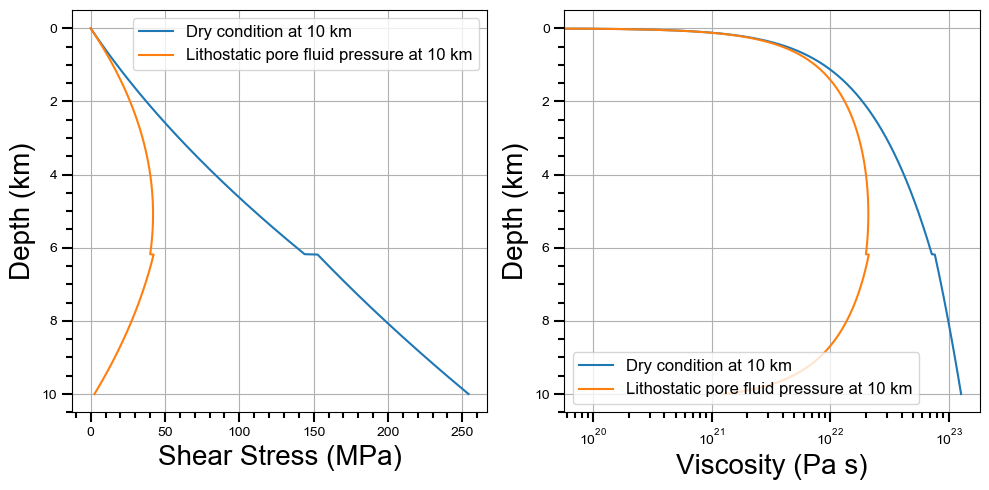

In [4]:
zs_t2002 = np.linspace(0.0, 10e3, 1000)
Ps = zs_t2002 * rho_m * g
lambdas_0 = Gerya_2002_lambda(zs_t2002, 0)
taus_0 = Rheology.Byerlee(Ps, _lambda=lambdas_0)
lambdas_1 = Gerya_2002_lambda(zs_t2002, 1)
taus_1 = Rheology.Byerlee(Ps, _lambda=lambdas_1)

n_z = np.argmax(taus_1)
tau_1_max = taus_1[n_z]
z_1_max = zs_t2002[n_z]
print("For 1, the maximum shear stress %.2f MPa is reached at depth %.2f km." % (tau_1_max/1e6, z_1_max/1e3))

fig = plt.figure(tight_layout=True, figsize=(10, 5))
gs = gridspec.GridSpec(1, 2)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus_0/1e6, zs_t2002/1e3, label="Dry condition at 10 km")
ax.plot(taus_1/1e6, zs_t2002/1e3, label="Lithostatic pore fluid pressure at 10 km")
ax.set_xlabel("Shear Stress (MPa)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
strain_rate = 1e-15  # second invariant
etas_0_t2002 = taus_0 / 2.0 / strain_rate
etas_1_t2002 = taus_1 / 2.0 / strain_rate
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(etas_0_t2002, zs_t2002/1e3, label="Dry condition at 10 km")
ax.semilogx(etas_1_t2002, zs_t2002/1e3, label="Lithostatic pore fluid pressure at 10 km")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()
print("For 1, the maximum effective viscosity is %.2e Pa (strain rate %.2e)" % (etas_1_t2002[n_z], strain_rate))

#### Example of a coulumb yielding from Garel etal 2014

A coulumb yielding criteria  (termed byerlee law otherwise. Actually I prefer to use the term Byerlee law for the specific experimentally determined law.):

${\mu}_{y} = \frac{min(\sigma_0 + f_c P, {\tau}_{y,max})}{2\dot{\epsilon_{ii}}}$

In modelling it's usually applied in combination with a maximum yield stress. 
Usually this value only takes effect below 30 km.
One can see this by adjusting the maximum depth of the following code block.

In the block, the values of variables are taken from the paper.

Text(0.5, 1.0, 'strain rate = 1.00e-13')

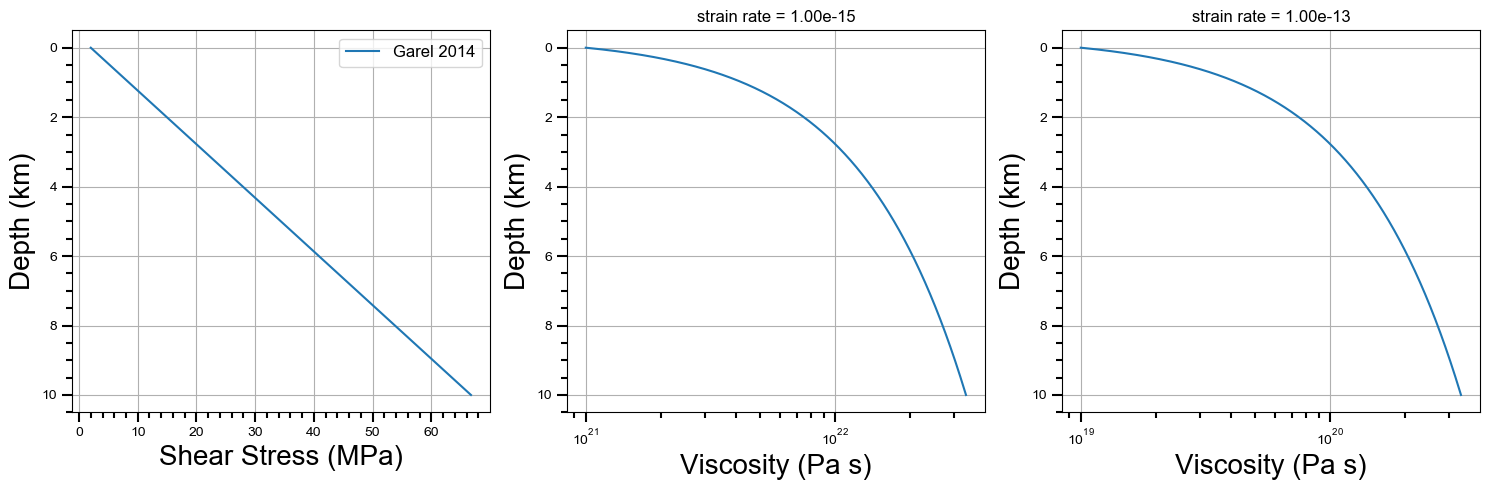

In [5]:
zs_g2014 = np.linspace(0.0, 10e3, 1000)
Ps = zs_g2014 * rho_m * g
tau_0 = 2e6
tau_m = 1000e6
friction = 0.2
taus_g2014 = Rheology.CoulumbYielding(Ps, tau_0, friction)

mask_limit = (taus_g2014 > tau_m)
taus_g2014[mask_limit] = tau_m


fig = plt.figure(tight_layout=True, figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus_g2014/1e6, zs_g2014/1e3, label="Garel 2014")
ax.set_xlabel("Shear Stress (MPa)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
strain_rate = 1e-15  # second invariant
etas_g2014 = taus_g2014 / 2.0 / strain_rate
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(etas_g2014, zs_g2014/1e3, label="Garel 2014")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# viscosity vs depth
strain_rate = 1e-13  # second invariant
etas_g2014 = taus_g2014 / 2.0 / strain_rate
ax = fig.add_subplot(gs[0, 2])
ax.semilogx(etas_g2014, zs_g2014/1e3, label="Garel 2014")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

#### Another example of Comloumb yielding, Agrusta 2017

I show this another example just to show a variation of values people used.
The author of this paper wrote their flow law as:
$${\mu}_{byerlee} = \frac{min(\sigma_0 + f_c P, {\sigma}_{max})}{\dot{\epsilon_{ii}}}$$
Where there is missing a factor of 2.0 in the deliminator.

Text(0.5, 1.0, 'strain rate = 1.00e-13')

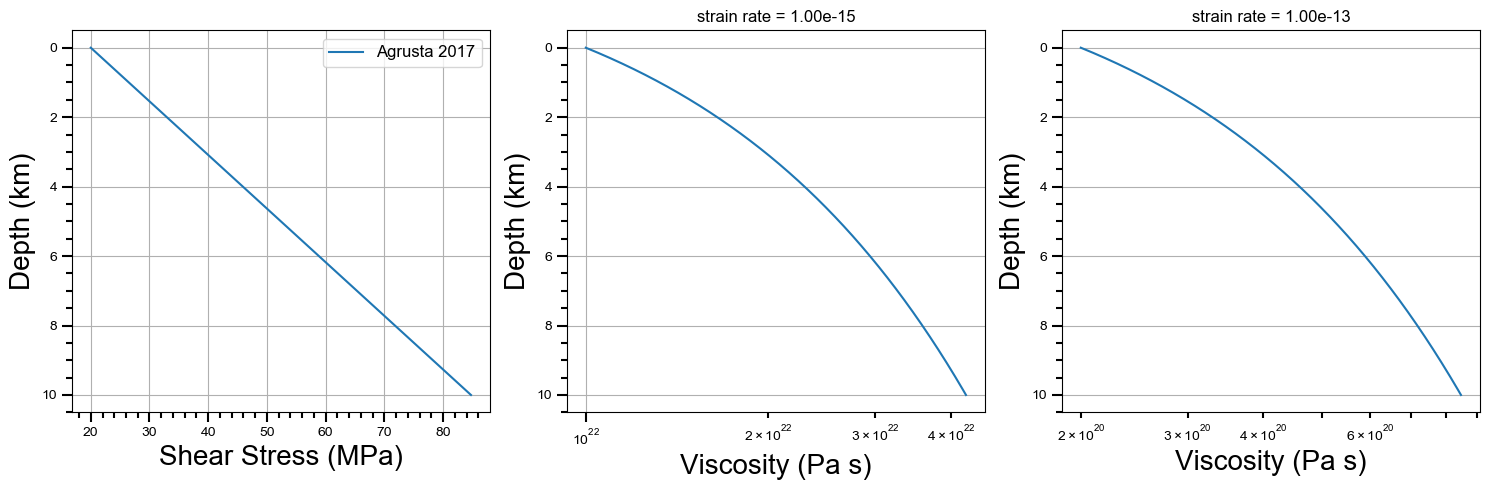

In [6]:
zs_a2017 = np.linspace(0.0, 10e3, 1000)
Ps = zs_a2017 * rho_m * g
tau_0 = 20e6
tau_m = 300e6
friction = 0.2
taus_a2017 = Rheology.CoulumbYielding(Ps, tau_0, friction)

mask_limit = (taus_a2017 > tau_m)
taus_a2017[mask_limit] = tau_m

fig = plt.figure(tight_layout=True, figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus_a2017/1e6, zs_a2017/1e3, label="Agrusta 2017")
ax.set_xlabel("Shear Stress (MPa)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
strain_rate = 1e-15  # second invariant
etas_a2017 = taus_a2017 / 2.0 / strain_rate
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(etas_a2017, zs_a2017/1e3, label="Agrusta 2017")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# viscosity vs depth
strain_rate = 1e-13  # second invariant
etas_a2017 = taus_a2017 / strain_rate
ax = fig.add_subplot(gs[0, 2])
ax.semilogx(etas_a2017, zs_a2017/1e3, label="Agrusta 2017")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

#### A third example of the Couloumb yielding: Billen 2018
This paper uses a very small value of surface cohesion of 0.1 MPa.
As we can see, this parameter is dominant in the first few kms, but have minimal impact below 10 km where the yield stress is on the order of 100 MPa.
Other paper chose to increase this value (also I chose to do that) because a small value maybe lead to strain rate localization along the surface and cause numerical issue.

Text(0.5, 1.0, 'strain rate = 1.00e-13')

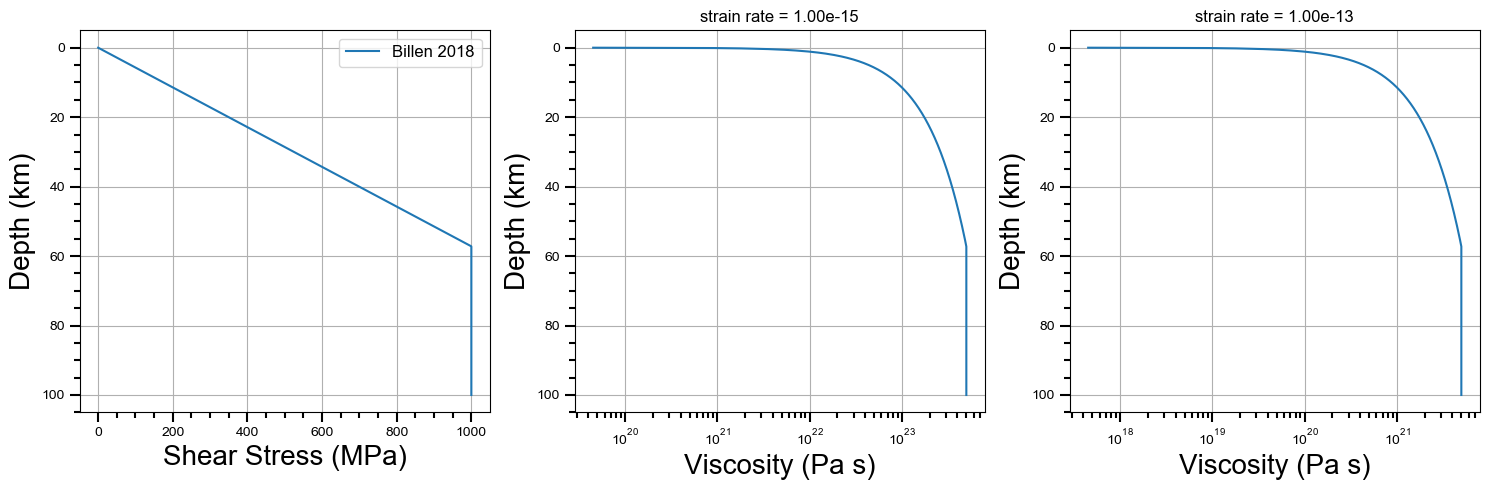

In [7]:
zs_b2018 = np.linspace(0.0, 100e3, 1000)
Ps = zs_b2018 * rho_m * g
tau_0 = 0.1e6
tau_m = 1000e6
friction = 0.6
_lambda = 0.1 # ? 0.1 or 0.9
taus_b2018 = Rheology.CoulumbYielding(Ps, tau_0, friction, _lambda)

mask_limit = (taus_b2018 > tau_m)
taus_b2018[mask_limit] = tau_m

fig = plt.figure(tight_layout=True, figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus_b2018/1e6, zs_b2018/1e3, label="Billen 2018")
ax.set_xlabel("Shear Stress (MPa)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
strain_rate = 1e-15  # second invariant
etas_b2018 = taus_b2018 / 2.0 / strain_rate
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(etas_b2018, zs_b2018/1e3, label="Billen 2018")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# viscosity vs depth
strain_rate = 1e-13  # second invariant
etas_b2018 = taus_b2018 / 2.0/ strain_rate
ax = fig.add_subplot(gs[0, 2])
ax.semilogx(etas_b2018, zs_b2018/1e3, label="Billen 2018")
ax.set_xlabel("Viscosity (Pa s)")
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

#### The Peierls stress
#####  The stress limiter approach
This approach is mentioned in the Cizcova 2013 paper.
In this paper, the author uses a value of $\tau_y = 500 MPa$ and we can see the yield stress is mostly constrained by this variable.

The dependence on the strain rate represents a strain rate strengthening.
With 2 orders of magnitude change in the strain rate, the Peierls stress increases by 1.5 fold.

This approach is not T dependent.
In terms of the strength profile, I think the advantage is to control the value of the Peierls stress regardless of the depth and thermal gradient.

In [8]:
tau_y = 500e6 # 500 Mpa
strain_rate_y = 1e-15
ny = 10
strain_rate = 1e-15
tau_sl_0 = Rheology.PeierlsStressLimiter(tau_y, strain_rate_y, ny, strain_rate)
eta_y_sl_0 = tau_sl_0 / strain_rate
print("At strain rate = %.2e, the yield stress is %.2e and the yield viscosity is %.2e" % (strain_rate, tau_sl_0, eta_y_sl_0))
strain_rate = 1e-14
tau_sl_1 = Rheology.PeierlsStressLimiter(tau_y, strain_rate_y, ny, strain_rate)
eta_y_sl_1 = tau_sl_1 / strain_rate
print("At strain rate = %.2e, the yield stress is %.2e and the yield viscosity is %.2e" % (strain_rate, tau_sl_1, eta_y_sl_1))
strain_rate = 1e-13
tau_sl_2 = Rheology.PeierlsStressLimiter(tau_y, strain_rate_y, ny, strain_rate)
eta_y_sl_2 = tau_sl_2 / strain_rate
print("At strain rate = %.2e, the yield stress is %.2e and the yield viscosity is %.2e" % (strain_rate, tau_sl_2, eta_y_sl_2))

At strain rate = 1.00e-15, the yield stress is 5.00e+08 and the yield viscosity is 5.00e+23
At strain rate = 1.00e-14, the yield stress is 6.29e+08 and the yield viscosity is 6.29e+22
At strain rate = 1.00e-13, the yield stress is 7.92e+08 and the yield viscosity is 7.92e+21


#### The Mei 2010 flow law

This is a flow law of Peierls creep from the Mei 2010 paper.
This flow law might be weaker than the Evans_Goetz 1979 flow law but should be stronger than all the other ones (e.g. the Idrissi 2016).

This is also a strain rate strengthening mechanism.
By looking the values, the effect is also about 1.5 fold when the strain rate increases 2 orders.

In the shallowest 30 km, this flow law has higher value of stress than 1000 Mpa.
Thus in a strength profile, it's cut off by the brittle yielding.

At deeper depth, this will be rewriten completely by ductile flow laws, so the effective range of depth is roughly 30 - 60 km.

/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Rheology.py:2122: RuntimeWarning: overflow encountered in exp
  expo = np.exp(exponential)
/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Rheology.py:2122: RuntimeWarning: overflow encountered in exp
  expo = np.exp(exponential)


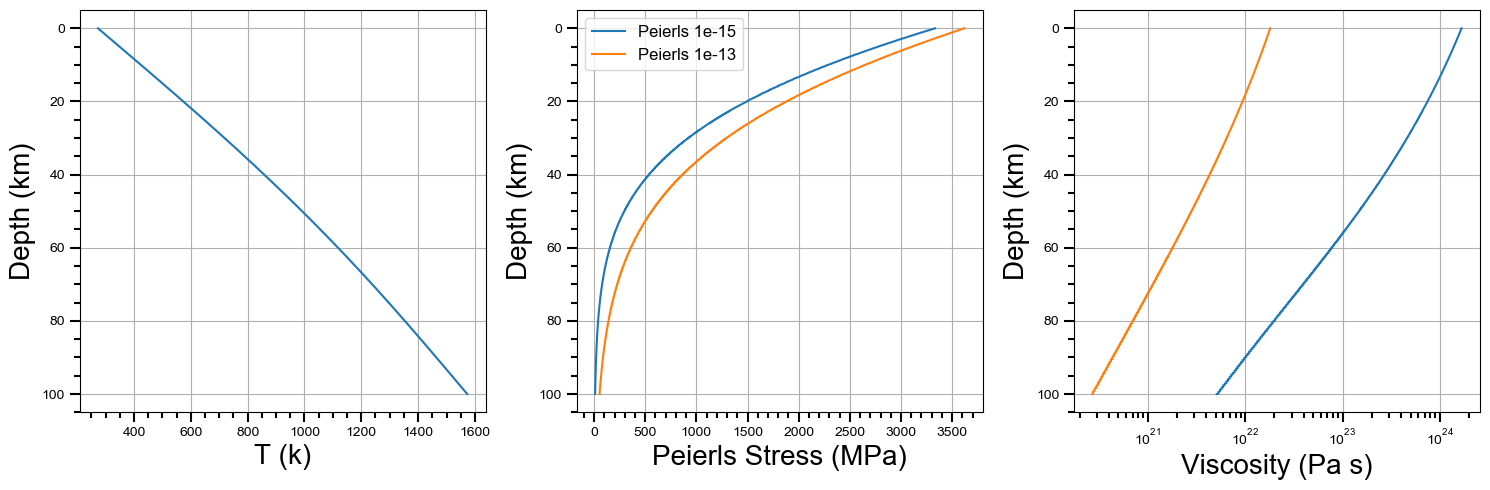

In [9]:
zs_peierls = np.linspace(0.0, 100e3, 1000)
Ps = zs_peierls * rho_m * g

age = 80 * Myr
PlateModel = ThermalModel.PLATE_MODEL(100e3, 1e-6, 273.15, 1573.0)
Ts = PlateModel.T(zs_peierls, age)

creep = Rheology.GetPeierlsRheology("MK10")

strain_rate = 1e-15
taus_peierls = np.zeros(zs_peierls.size) # Mpa
for i in range(zs_peierls.size):
    taus_peierls[i] = Rheology.PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i])
eta_peierls1 = taus_peierls * 1e6 / 2.0 / strain_rate

fig = plt.figure(tight_layout=True, figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

# T vs depth
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(Ts, zs_peierls/1e3, label="Plate model with thikness of 100 km")
ax0.set_xlabel("T (k)")
ax0.invert_yaxis()
ax0.set_ylabel("Depth (km)")
ax0.grid()

# shear stress vs depth
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(taus_peierls, zs_peierls/1e3, label="Peierls %s" % strain_rate)
ax1.set_xlabel("Peierls Stress (MPa)")
ax1.invert_yaxis()
ax1.set_ylabel("Depth (km)")
ax1.grid()

# viscosity vs depth
etas_peierls = taus_peierls*1e6 / 2.0 / strain_rate
ax2 = fig.add_subplot(gs[0, 2])
ax2.semilogx(eta_peierls1, zs_peierls/1e3, label="Peierls %s" % strain_rate)
ax2.set_xlabel("Viscosity (Pa s)")
ax2.invert_yaxis()
ax2.set_ylabel("Depth (km)")
ax2.grid()

strain_rate = 1e-13
taus_peierls = np.zeros(zs_peierls.size)
for i in range(zs_peierls.size):
    taus_peierls[i] = Rheology.PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i])
eta_peierls2 = taus_peierls * 1e6 / 2.0 / strain_rate

ax1.plot(taus_peierls, zs_peierls/1e3, label="Peierls %s" % strain_rate)
ax2.semilogx(eta_peierls2, zs_peierls/1e3, label="Peierls %s" % strain_rate)

ax1.legend()

#### The Strength profile

In this block, I plot a strength profile combining brittle yielding, low-T plasticity and the dutile flow laws

I reintroduced the strength as
$$ \sigma = 2 * \eta_{eff} * \dot{\epsilon}$$
, where the $\eta_{eff}$ is the value of the effective viscosity from the composite rheology.

Moreover, I show the differences between result of Dragar-Prager yielding scheme (DP) and the stress-limiter yielding scheme (SL) implemented both in the ASPECT's visco_plastic module.
The SL takes the composite result of the brittle rheology and the pre-yielding rheology so it arrives at a smaller value by $~2.0$ compared to the DP.

The differences from the profiles with the Peiels creep and the profile without are trivial in this plot.
This results from the dislocation creep being week on itself and dominate the deformation in the range that we plotted.
The only difference is in the 40 - 60 km range, where the composite rheology from the Peierls would lower the strength.
One should notice that the Peierls creep we are using (Mei etal 03) doesn't have a activation pressure, so that at deeper depth, the Peierls rheology could be reintroduced as the dominant regime.

Furthermore, I tested the Peierls rheology by making
$$ min(\eta_{peierls}, \eta_{dfds}) $$
as the composite rheology.
This features the competing nature of the Peierls rheology and the dislocation creep rheology.
In the current scope, this approximates the one without the Peierls creep for the reason afore-mentioned.

/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Rheology.py:2122: RuntimeWarning: overflow encountered in exp
  expo = np.exp(exponential)


Diffusion creep (in UI): 
{'A': 1.2268034188036272e-17, 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 285000.0, 'V': 6.9e-06}
Dislocation creep (in UI): 
{'A': 1.231264408537834e-17, 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 490000.0, 'V': 1.34e-05}
Peierls creep (not in UI): 
{'q': 1.0, 'p': 0.5, 'n': 2.0, 'sigp0': 5900.0, 'A': 1.4e-07, 'E': 320000.0, 'V': 0.0, 'Tref': 873.0, 'Pref': 4500000000.0}
save figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/Peierls_Yielding_Compare_Strength_Profile_1.00e-14.pdf


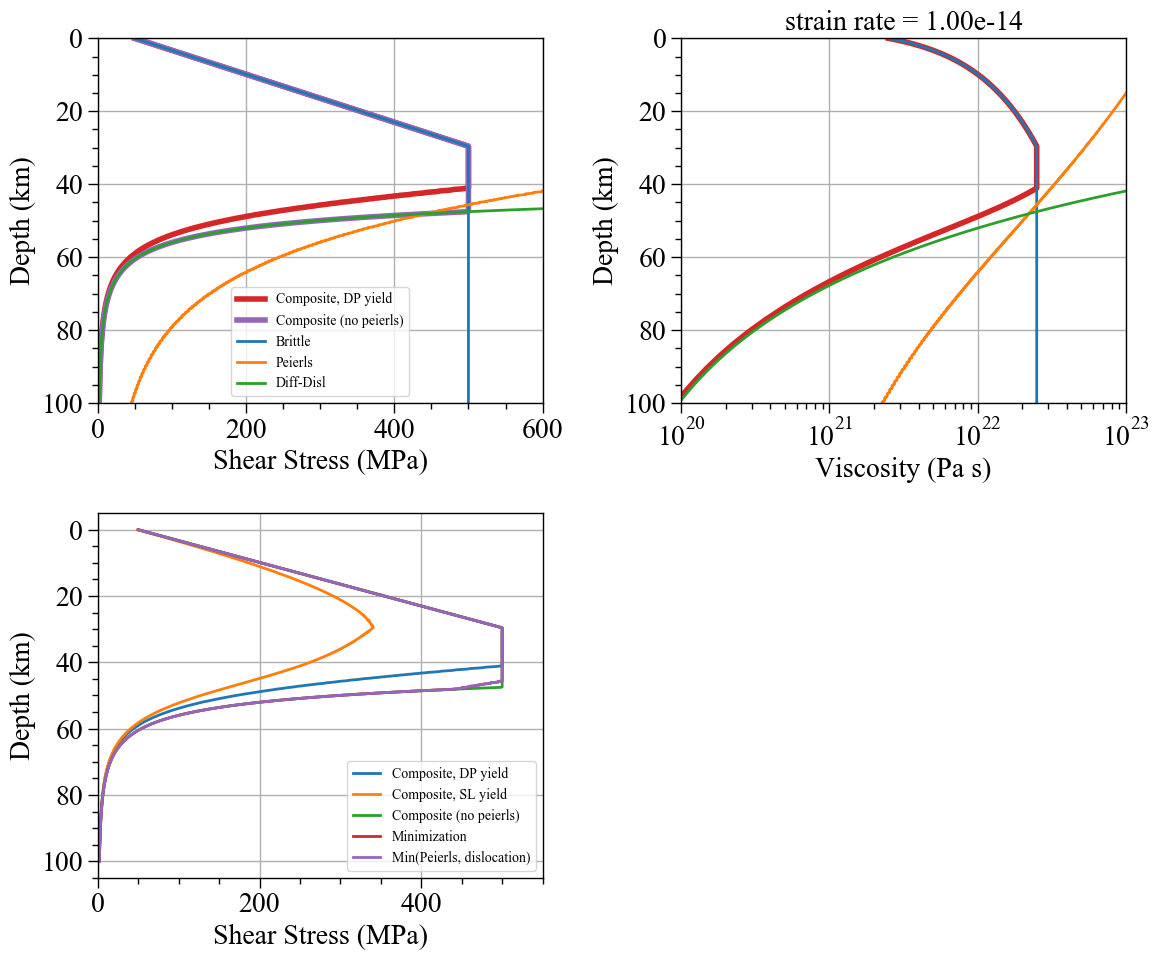

In [17]:
# Scaling parameters for plots.
scaling_factor = 2.0  # General scaling factor for the plot size.
font_scaling_multiplier = 1.0  # Extra scaling for fonts.
legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
line_width_scaling_multiplier = 1.0  # Extra scaling for line widths.

# Scale matplotlib parameters based on specified factors.
plot_helper.scale_matplotlib_params(
    scaling_factor, 
    font_scaling_multiplier=font_scaling_multiplier,
    legend_font_scaling_multiplier=legend_font_scaling_multiplier,
    line_width_scaling_multiplier=line_width_scaling_multiplier
)

# Update font settings for compatibility with publishing tools like Illustrator.
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

# pressure profile
zs_test = np.linspace(0.0, 100e3, 1000)
Ps = zs_test * rho_m * g

# thermal model
age = 80 * Myr
PlateModel = ThermalModel.PLATE_MODEL(150e3, 1e-6, 273.15, 1673.0)
Ts = PlateModel.T(zs_test, age)

# strain rate to use
strain_rate = 1e-14

# brittle yielding
tau_0 = 50e6
tau_m = 500e6
friction = 0.47
taus_test_brittle = Rheology.CoulumbYielding(Ps, tau_0, friction)
mask_limit = (taus_test_brittle > tau_m)
taus_test_brittle[mask_limit] = tau_m
eta_brittle = taus_test_brittle / 2.0 / strain_rate

# peierls creep
creep = Rheology.GetPeierlsRheology("MK10")
taus_peierls = np.zeros(zs_test.size) # Mpa
for i in range(zs_test.size):
    taus_peierls[i] = Rheology.PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i])
eta_peierls = taus_peierls * 1e6 / 2.0 / strain_rate

# diffusion & dislocation creep
# here I took the parameterization for my 2d cases
da_file = os.path.join(ASPECT_LAB_DIR, 'tests', 'integration', 'fixtures', 'test_rheology', 'depth_average.txt')
assert(os.path.isfile(da_file))
Operator = Rheology.RHEOLOGY_OPR()
Operator.ReadProfile(da_file)
rheology_aspect, viscosity_profile = Operator.MantleRheology(rheology="HK03_wet_mod", dEdiff=-40e3, dEdisl=30e3,\
dVdiff=-5.5e-6, dVdisl=2.12e-6, dAdiff_ratio=0.33333247873, dAdisl_ratio=1.040297619,\
jump_lower_mantle=15.0, Coh=300.0)
diffusion_aspect = rheology_aspect['diffusion_creep']
eta_diffusion = Rheology.CreepRheologyInAspectViscoPlastic(diffusion_aspect, strain_rate, Ps, Ts)
taus_diffusion = 2 * strain_rate * eta_diffusion
dislocation_aspect = rheology_aspect['dislocation_creep']
eta_dislocation = Rheology.CreepRheologyInAspectViscoPlastic(dislocation_aspect, strain_rate, Ps, Ts)
taus_dislocation = 2 * strain_rate * eta_dislocation

eta_dfds = 1.0 / (1.0 / eta_diffusion + 1.0 / eta_dislocation)
taus_dfds = 2 * strain_rate * eta_dfds

# print the value in the flow law
print("Diffusion creep (in UI): ")
print(diffusion_aspect)
print("Dislocation creep (in UI): ")
print(dislocation_aspect)
print("Peierls creep (not in UI): ")
print(creep)



# get the composite rheology
eta = 1.0 / (1.0/eta_brittle + 1.0/eta_peierls + 1.0/eta_dfds)
eta1 = np.minimum(eta_peierls, eta_dfds)  # minimum
eta1 = np.minimum(eta_brittle, eta1)
eta2 = np.minimum(eta_brittle, 1.0 / (1.0 / eta_peierls + 1.0/eta_dfds)) # DP yield
eta3 = np.minimum(eta_brittle, 1.0/(1.0 / np.minimum(eta_peierls, eta_dislocation) + 1.0 / eta_diffusion)) # competing Peierls and Dislocation
eta_nopc = np.minimum(eta_brittle, eta_dfds)
taus = 2 * strain_rate * eta
taus1 = 2 * strain_rate * eta1
taus2 = 2 * strain_rate * eta2
taus3 = 2 * strain_rate * eta3
taus_nopc = 2 * strain_rate * eta_nopc

# get the minimum
taus_minimum = np.minimum(taus_test_brittle, taus_peierls*1e6)
taus_minimum = np.minimum(taus_minimum, taus_dfds)

fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus2/1e6, zs_test/1e3, color=default_colors[3], linewidth=line_width_scaling_multiplier*4.0, label="Composite, DP yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, color=default_colors[4], linewidth=line_width_scaling_multiplier*4.0, label="Composite (no peierls)")
ax.plot(taus_test_brittle/1e6, zs_test/1e3, '-', color=default_colors[0], linewidth=line_width_scaling_multiplier*2.0, label="Brittle")
ax.plot(taus_peierls, zs_test/1e3, '-', color=default_colors[1], label="Peierls") # peierls is MPa
ax.plot(taus_dfds/1e6, zs_test/1e3, '-', color=default_colors[2], label="Diff-Disl")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, 600.0])
ax.set_ylim([0, 100.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(eta2, zs_test/1e3, color=default_colors[3], linewidth=line_width_scaling_multiplier*4.0, label="Composite, DP yield")
ax.semilogx(eta_brittle, zs_test/1e3, color=default_colors[0], linewidth=line_width_scaling_multiplier*2.0, label="Brittle")
ax.semilogx(eta_peierls, zs_test/1e3, color=default_colors[1], linewidth=line_width_scaling_multiplier*2.0, label="Peierls")
ax.semilogx(eta_dfds, zs_test/1e3, color=default_colors[2], linewidth=line_width_scaling_multiplier*2.0, label="Diff-Disl")
ax.set_xlabel("Viscosity (Pa s)")
ax.set_xlim([1e20, 1e23])
ax.set_ylim([0, 100.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# shear stress vs depth
ax = fig.add_subplot(gs[1, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus/1e6, zs_test/1e3, label="Composite, SL yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus1/1e6, zs_test/1e3, label="Minimization")
ax.plot(taus3/1e6, zs_test/1e3, label="Min(Peierls, dislocation)")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# Adjust spine thickness for this plot
all_axes = fig.get_axes()
for ax in all_axes:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

fig_path = os.path.join(RESULT_DIR, "Peierls_Yielding_Compare_Strength_Profile_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("save figure: %s" % fig_path)

In [ ]:
print(dislocation_aspect)

#### Deformation mechanism

Next, I plot the deformation mechanism of

    diffusion - 0
    dislocation - 1
    Peierls - 2
    Brittle - 3

The diagrams of viscosity and viscous stress are plotted after the d-m plot.
The d-m plot shows the activation of brittle deformation at shallow depth and cold enviroment.
And it also asserts the dominance of the dislocation creep below the surface.

In [ ]:
# deformation mechanism

strain_rate = 1e-14

Tmin = 273.0
Tmax = 1973.0
nT = 100
Pmin = 0.0
Pmax = 25e9
nP = 200
Ts = np.linspace(Tmin, Tmax, nT)
Ps = np.linspace(Pmin, Pmax, nP)
TT, PP = np.meshgrid(Ts, Ps)

# brittle
tautau_test_brittle = Rheology.CoulumbYielding(PP, tau_0, friction)
mask_limit = (tautau_test_brittle > tau_m)
tautau_test_brittle[mask_limit] = tau_m
etaeta_brittle = tautau_test_brittle / 2.0 / strain_rate

# peierls creep
creep = Rheology.GetPeierlsRheology("MK10")
tautau_peierls = np.zeros(TT.shape) # Mpa
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        tautau_peierls[i, j] = Rheology.PeierlsCreepStress(creep, strain_rate, PP[i, j], TT[i, j])
etaeta_peierls = tautau_peierls * 1e6 / 2.0 / strain_rate

# diffusion dislocation
etaeta_diffusion = Rheology.CreepRheologyInAspectViscoPlastic(diffusion_aspect, strain_rate, PP, TT)
etaeta_dislocation = Rheology.CreepRheologyInAspectViscoPlastic(dislocation_aspect, strain_rate, PP, TT)
etaeta_dfds = 1.0 / (1.0 / etaeta_diffusion + 1.0 / etaeta_dislocation)
tautau_dfds = 2 * strain_rate * etaeta_dfds

DM = np.zeros(TT.shape)
etaeta = np.zeros(TT.shape)
temp = np.zeros(4)
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        temp[0] = etaeta_diffusion[i, j]
        temp[1] = etaeta_dislocation[i, j]
        temp[2] = etaeta_peierls[i, j]
        temp[3] = etaeta_brittle[i, j]
        dm = np.argmin(temp)
        DM[i, j] = dm
        etaeta[i, j] = temp[dm]
tautau = 2 * etaeta * strain_rate

# plot deformation mechanism
fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

# deformation mechanism
ax = fig.add_subplot(gs[0, 0])
h = ax.pcolormesh(TT, PP/1e9, DM, cmap=ccm.vik)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="Mechanism")
ax.set_title("Strain Rate = %.2e" % strain_rate)

# Peierls viscosity
ax = fig.add_subplot(gs[0, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta_peierls), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Peierls Viscosity (Pa s))")

# viscosity
ax = fig.add_subplot(gs[1, 0])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity (Pa s))")

# strength
ax = fig.add_subplot(gs[1, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(tautau), vmin=3, vmax=9, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Stress (Pa))")

fig_path = os.path.join(RESULT_DIR, "deformation_mechanism_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("Figure saved: ", fig_path)

### Turn off the Peierls creep rheology
In the next block, the Peierls creep rheology is turned off by assigning a very big value (${10}^{31} Pa s$).
The result could be then compared to the previous one.
An additional plot of the difference of the viscosity is generated:
$$log (\eta_1 / \eta)$$
Note the next block must be ran after the previous one.

The result is a bigger value by at most 1 order of magnitude.
For this to happen, T must be bigger than 1000 K and P must be big to dominate the dislocation creep.

In [ ]:
# peierls creep
etaeta_peierls = 1e31 * np.ones(TT.shape)

DM = np.zeros(TT.shape)
etaeta1 = np.zeros(TT.shape)
temp = np.zeros(4)
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        temp[0] = etaeta_diffusion[i, j]
        temp[1] = etaeta_dislocation[i, j]
        temp[2] = etaeta_peierls[i, j]
        temp[3] = etaeta_brittle[i, j]
        dm = np.argmin(temp)
        DM[i, j] = dm
        etaeta1[i, j] = temp[dm]
tautau = 2 * etaeta1 * strain_rate

# plot deformation mechanism
fig = plt.figure(tight_layout=True, figsize=(12, 15))
gs = gridspec.GridSpec(3, 2)

# deformation mechanism
ax = fig.add_subplot(gs[0, 0])
h = ax.pcolormesh(TT, PP/1e9, DM, cmap=ccm.vik)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="Mechanism")
ax.set_title("Strain Rate = %.2e" % strain_rate)

# Peierls viscosity
ax = fig.add_subplot(gs[0, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta_peierls), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Peierls Viscosity (Pa s))")

# viscosity
ax = fig.add_subplot(gs[1, 0])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta1), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity (Pa s))")

# strength
ax = fig.add_subplot(gs[1, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(tautau), vmin=3, vmax=9, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Stress (Pa))")

# the difference
ax = fig.add_subplot(gs[2, 0])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta1/etaeta), vmin=-2, vmax=2, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity Difference)")

fig_path = os.path.join(RESULT_DIR, "deformation_mechanism_psd_1_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("Figure saved: ", fig_path)

#### Compute the Peierls creep differently

In the next block, I compute the Peierls creep by assigning a value of activation volume to it.

Note this is definitely not the correct thing to do.
First the activation volume doesn't mean the same thing for the Peirls creep (check Lars Hansen's 2019 paper, eq 7 - 9).
Then even if we have to insert such a term into the activation enthalpy, we'll need to refit the flow law (the A value).

In [ ]:
dV = dislocation_aspect['V']

# peierls creep
tautau_peierls = np.zeros(TT.shape) # Mpa
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        tautau_peierls[i, j] = Rheology.PeierlsCreepStress(creep, strain_rate, PP[i, j], TT[i, j], dV=dV)
etaeta_peierls = tautau_peierls * 1e6 / 2.0 / strain_rate

DM = np.zeros(TT.shape)
etaeta2 = np.zeros(TT.shape)
temp = np.zeros(4)
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        temp[0] = etaeta_diffusion[i, j]
        temp[1] = etaeta_dislocation[i, j]
        temp[2] = etaeta_peierls[i, j]
        temp[3] = etaeta_brittle[i, j]
        dm = np.argmin(temp)
        DM[i, j] = dm
        etaeta2[i, j] = temp[dm]
tautau = 2 * etaeta2 * strain_rate

# plot deformation mechanism
fig = plt.figure(tight_layout=True, figsize=(12, 15))
gs = gridspec.GridSpec(3, 2)

# deformation mechanism
ax = fig.add_subplot(gs[0, 0])
h = ax.pcolormesh(TT, PP/1e9, DM, cmap=ccm.vik)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="Mechanism")
ax.set_title("Strain Rate = %.2e" % strain_rate)

# Peierls viscosity
ax = fig.add_subplot(gs[0, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta_peierls), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Peierls Viscosity (Pa s))")

# viscosity
ax = fig.add_subplot(gs[1, 0])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta2), vmin=18, vmax=24, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity (Pa s))")

# strength
ax = fig.add_subplot(gs[1, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(tautau), vmin=3, vmax=9, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Stress (Pa))")


# the difference
ax = fig.add_subplot(gs[2, 0])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta2/etaeta), vmin=-2, vmax=2, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity Difference)")

# the difference
ax = fig.add_subplot(gs[2, 1])
h = ax.pcolormesh(TT, PP/1e9, np.log10(etaeta2/etaeta1), vmin=-2, vmax=2, cmap=ccm.roma)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.invert_yaxis()
fig.colorbar(h, ax=ax, label="log10(Viscosity Difference)")

fig_path = os.path.join(RESULT_DIR, "deformation_mechanism_psd_2_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("Figure saved: ", fig_path)

Also plot the shallow strength profile

In [ ]:
# pressure profile
zs_test = np.linspace(0.0, 100e3, 1000)
Ps = zs_test * rho_m * g

# thermal model
age = 80 * Myr
PlateModel = ThermalModel.PLATE_MODEL(150e3, 1e-6, 273.15, 1673.0)
Ts = PlateModel.T(zs_test, age)

# strain rate to use
strain_rate = 1e-14

# brittle yielding
tau_0 = 50e6
tau_m = 500e6
friction = 0.47
taus_test_brittle = Rheology.CoulumbYielding(Ps, tau_0, friction)
mask_limit = (taus_test_brittle > tau_m)
taus_test_brittle[mask_limit] = tau_m
eta_brittle = taus_test_brittle / 2.0 / strain_rate

# peierls creep
creep = Rheology.GetPeierlsRheology("MK10")
taus_peierls = np.zeros(zs_test.size) # Mpa
for i in range(zs_test.size):
    taus_peierls[i] = Rheology.PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i], dV=dV)
eta_peierls = taus_peierls * 1e6 / 2.0 / strain_rate

# diffusion & dislocation creep
# here I took the parameterization for my 2d cases
da_file = os.path.join(ASPECT_LAB_DIR, 'tests', 'integration', 'fixtures', 'test_rheology', 'depth_average.txt')
assert(os.path.isfile(da_file))
Operator = Rheology.RHEOLOGY_OPR()
Operator.ReadProfile(da_file)
rheology_aspect, viscosity_profile = Operator.MantleRheology(rheology="HK03_wet_mod", dEdiff=-40e3, dEdisl=30e3,\
dVdiff=-5.5e-6, dVdisl=2.12e-6, dAdiff_ratio=0.33333247873, dAdisl_ratio=1.040297619,\
jump_lower_mantle=15.0, Coh=300.0)
diffusion_aspect = rheology_aspect['diffusion_creep']
eta_diffusion = Rheology.CreepRheologyInAspectViscoPlastic(diffusion_aspect, strain_rate, Ps, Ts)
taus_diffusion = 2 * strain_rate * eta_diffusion
dislocation_aspect = rheology_aspect['dislocation_creep']
eta_dislocation = Rheology.CreepRheologyInAspectViscoPlastic(dislocation_aspect, strain_rate, Ps, Ts)
taus_dislocation = 2 * strain_rate * eta_dislocation

eta_dfds = 1.0 / (1.0 / eta_diffusion + 1.0 / eta_dislocation)
taus_dfds = 2 * strain_rate * eta_dfds

# print the value in the flow law
print("Diffusion creep (in UI): ")
print(diffusion_aspect)
print("Dislocation creep (in UI): ")
print(dislocation_aspect)
print("Peierls creep (not in UI): ")
print(creep)



# get the composite rheology
eta = 1.0 / (1.0/eta_brittle + 1.0/eta_peierls + 1.0/eta_dfds)
eta1 = np.minimum(eta_peierls, eta_dfds)  # minimum
eta1 = np.minimum(eta_brittle, eta1)
eta2 = np.minimum(eta_brittle, 1.0 / (1.0 / eta_peierls + 1.0/eta_dfds)) # DP yield
eta3 = np.minimum(eta_brittle, 1.0/(1.0 / np.minimum(eta_peierls, eta_dislocation) + 1.0 / eta_diffusion)) # competing Peierls and Dislocation
eta_nopc = np.minimum(eta_brittle, eta_dfds)
taus = 2 * strain_rate * eta
taus1 = 2 * strain_rate * eta1
taus2 = 2 * strain_rate * eta2
taus3 = 2 * strain_rate * eta3
taus_nopc = 2 * strain_rate * eta_nopc

# get the minimum
taus_minimum = np.minimum(taus_test_brittle, taus_peierls*1e6)
taus_minimum = np.minimum(taus_minimum, taus_dfds)

fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus_test_brittle/1e6, zs_test/1e3, 'b--', label="Brittle")
ax.plot(taus_peierls, zs_test/1e3, 'c--', label="Peierls") # peierls is MPa
ax.plot(taus_dfds/1e6, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(eta2, zs_test/1e3, label="Composite, DP yield")
ax.semilogx(eta_brittle, zs_test/1e3, 'b--', label="Brittle")
ax.semilogx(eta_peierls, zs_test/1e3, 'c--', label="Peierls")
ax.semilogx(eta_dfds, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Viscosity (Pa s)")
ax.set_xlim([np.amin(eta)/10.0, np.amax(eta)*10.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# shear stress vs depth
ax = fig.add_subplot(gs[1, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus/1e6, zs_test/1e3, label="Composite, SL yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus1/1e6, zs_test/1e3, label="Minimization")
ax.plot(taus3/1e6, zs_test/1e3, label="Min(Peierls, dislocation)")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

fig_path = os.path.join(RESULT_DIR, "Peierls_Yielding_Compare_Strength_Profile_2_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("save figure: %s" % fig_path)